# How to generate histograms using YugabyteDB (PostgreSQL-compatible)

This provides and example of how to generate frequency histograms using YugabyteDB.  
Disambiguation: we refer here to computing histograms of table data, rather than histograms of the columns statistics used by the cost based optimizer.

Author and contacts: Luca.Canali@cern.ch

## Setup and prerequisites

### This is how you can setup an YugabyteDB instance for testing using a Docker image

`docker run --name yb -p5433:5433 -p7000:7000 yugabytedb/yugabyte:latest yugabyted start --daemon=false`

connect to YugabyteDB:
 - DB is on port 5433
 - WebUI is on port 7000


### This is how you set up a YugabyteDB test cluster:

`docker network create -d bridge yb`

`docker run -d --name yb0 --hostname yb0 --net=yb -p5433:5433 -p7000:7000 yugabytedb/yugabyte:latest yugabyted start --daemon=false --listen yb0 --tserver_flags="ysql_enable_auth=false"`

wait and check logs
`docker logs -f yb0`

start node 2 and 3 (follow the pattern for more nodes)

`docker run -d --name yb1 --hostname yb1 --net=yb -p5434:5433 yugabytedb/yugabyte:latest yugabyted start --daemon=false --listen yb1 --tserver_flags="ysql_enable_auth=false" --join yb0 `

`docker run -d --name yb2 --hostname yb2 --net=yb -p5435:5433 yugabytedb/yugabyte:latest yugabyted start --daemon=false --listen yb2 --tserver_flags="ysql_enable_auth=false" --join yb0`


connect to YugabyteDB:
 - Connect to any node, for example yb0 on port 5433
 - WebUI is on port 7000



Install the Python library for connecting to PostgreSQL  

`pip install psycopg2-binary`

## Create the test table

In [1]:
# connect to PostgreSQL using psycopg2 
# !pip install psycopg2-binary

import psycopg2

# Connect to an existing database and create the test table

with psycopg2.connect("dbname=yugabyte user=yugabyte host=localhost port=5433") as yb_conn:
    cur = yb_conn.cursor()
    
    # use this drop statement if you need to recreate the table
    cur.execute("DROP TABLE if exists data")

    cur.execute("CREATE TABLE data as select random()*100 random_value from generate_series(1, 100);")
   

## Define the query to compute the histogram

In [2]:
table_name = "data" # table or temporary view containing the data
value_col = "random_value" # column name on which to compute the histogram
min = -20  # min: minimum value in the histogram
max = 90   # maximum value in the histogram
bins = 11  # number of histogram buckets to compute
step = (max - min) / bins
        
query = f"""
with hist as (
  select 
      width_bucket({value_col}, {min}, {max}, {bins}) as bucket,
      count(*) as cnt
  from {table_name}
  group by bucket
),
buckets as (
  select generate_series as bucket from generate_series(1,{bins})
)
select
    bucket, {min} + (bucket - 0.5) * {step} as value,
    coalesce(cnt, 0) as count
from hist right outer join buckets using(bucket)
order by bucket
"""
    

## Fetch the histogram data into a Pandas dataframe using SQLAlchemy

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# create SQLAlchemy engine
engine = create_engine("postgresql+psycopg2://yugabyte@localhost:5433/yugabyte")

hist_pandasDF = pd.read_sql(query, engine)  

In [4]:
# Schema description
#
# bucket: the bucket number, range from 1 to bins (included)
# value: midpoint value of the given bucket
# count: number of values in the bucket    
            
hist_pandasDF

,bucket,value,count
0,1,-15.0,0
1,2,-5.0,0
2,3,5.0,7
3,4,15.0,9
4,5,25.0,7
5,6,35.0,8
6,7,45.0,11
7,8,55.0,13
8,9,65.0,12
9,10,75.0,11


In [5]:
# Optionally normalize the event count into a frequency
# dividing by the total number of events
 
hist_pandasDF["frequency"] = hist_pandasDF["count"] / sum(hist_pandasDF["count"]) 
              
hist_pandasDF

,bucket,value,count,frequency
0,1,-15.0,0,0.000000
1,2,-5.0,0,0.000000
2,3,5.0,7,0.077778
3,4,15.0,9,0.100000
4,5,25.0,7,0.077778
5,6,35.0,8,0.088889
6,7,45.0,11,0.122222
7,8,55.0,13,0.144444
8,9,65.0,12,0.133333
9,10,75.0,11,0.122222


## Histogram plotting

The first plot is a histogram with the event counts (number of events per bin).
The second plot is a histogram of the events frequencies (number of events per bin normalized by the sum of the events).


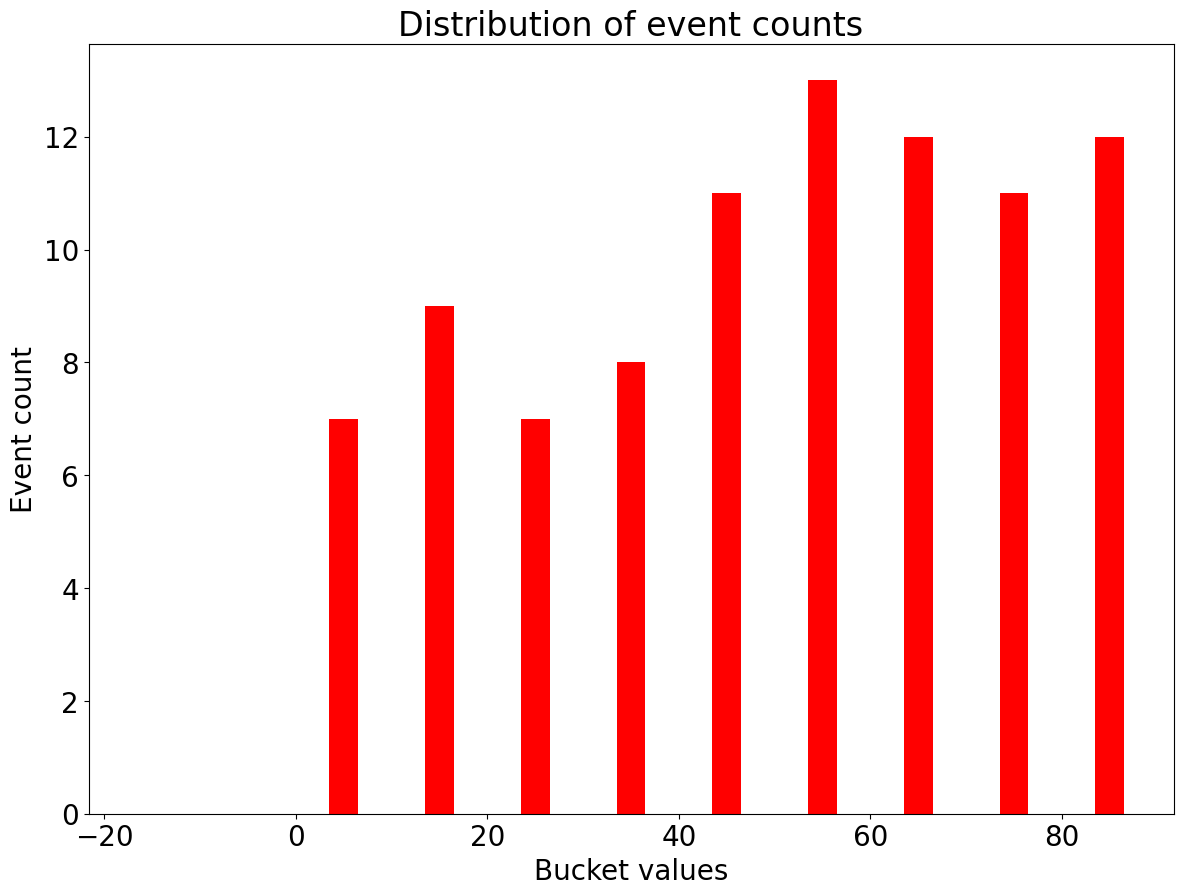

In [6]:
import matplotlib.pyplot as plt 

plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["count"]

# bar plot
ax.bar(x, y, width = 3.0, color='red')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event count")
ax.set_title("Distribution of event counts")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()


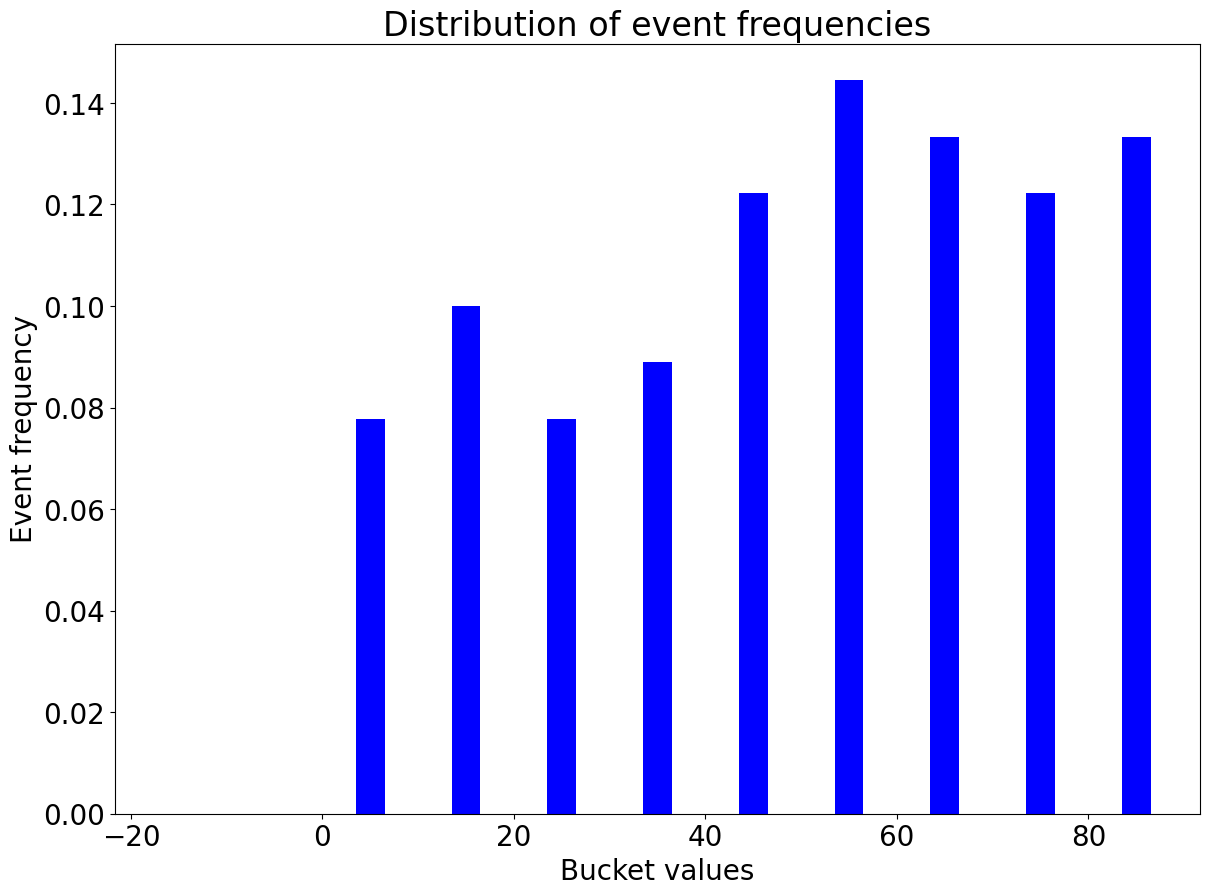

In [7]:
import matplotlib.pyplot as plt 

plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["frequency"]

# bar plot
ax.bar(x, y, width = 3.0, color='blue')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event frequency")
ax.set_title("Distribution of event frequencies")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()
